In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

In [2]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, ticker as mtick
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

In [2]:
sns.set(
    rc={
        "figure.figsize" : (10, 6.25)
        , "axes.facecolor" : "xkcd:white"
        , "figure.facecolor" : "xkcd:parchment"
        , 'grid.color' : 'xkcd:light gray'
        , 'axes.edgecolor' : 'black'
    }
)

# Change the billboard_observation_date!

In [3]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2024-12-10'

In [4]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [5]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [6]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;

,Success


# Update upload/rank_by_name

In [7]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [8]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
from upload.rank_by_name import rankings
# from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

['A Bar Song (Tipsy)',
 'I Had Some Help',
 'Love Somebody',
 'I Am Not Okay',
 'High Road',
 '...',
 'Thoughts Of You',
 "This World's A Giant",
 'Cowboys Cry Too',
 'Bad Luck',
 'Backseat Driver']

In [9]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [10]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|    |   song_id | song_name          | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-------------------|:--------------|:--------------------|---------------------------:|
| 28 |        34 | A Bar Song (Tipsy) | Shaboozey     | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------|:--------------|:--------------------|---------------------------:|
|  31 |        38 | I Had Some Help | Morgan Wallen | Other main artist   |                          0 |
| 214 |        38 | I Had Some Help | Post Malone   | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name     | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:--------------|:--------------|:--------------------|---

Please enter the song_id or 'New Song'

|     |   song_id | song_name      | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:---------------|:--------------|:--------------------|---------------------------:|
| 179 |       210 | Gonna Love You | Parmalee      | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id |   song_name | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|------------:|:--------------|:--------------------|---------------------------:|
| 48 |        57 |          28 | Zach Bryan    | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name      | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:---------------|:--------------|:--------------------|---------------------------:|
|  77 |        93 | Boys Back Home | Dylan Scott   | Other m

Please enter the song_id or 'New Song'

|     |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:------------|:--------------|:--------------------|---------------------------:|
|  64 |        77 | Losers      | Jelly Roll    | Featured artist     |                          0 |
| 224 |        77 | Losers      | Post Malone   | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------|:--------------|:--------------------|---------------------------:|
| 151 |       179 | A Lot More Free | Max McNown    | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name            | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:---------------------|:--------

In [11]:
# Be aware that some "last week on chart" are one too high. Audit, esp. when the song is marked new in backfillery

# Notes
#### s2a for:

#### Untracked weeks to 0 for


In [11]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(list(new_song_to_rank.keys()))

49 +
['Thoughts Of You']


### Add artists on any new songs that aren't in the artist table yet to its CSV

In [12]:
df_artist = pd.read_csv('source_data/artist.csv')

Thoughts Of You: Ole 60(66)

In [13]:
new_song_artists = [
    'Ole 60'
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
65,66,Ole 60,0.0,2024-09-13


In [14]:
df_artist['artist_id'].max()

119

In [15]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [120, 'Paul Cauthen', 0, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [17]:
df_artist.to_csv('source_data/artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-12-03


### Add all new songs to the song table CSV

In [14]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [15]:
# Reduce untracked weeks by one for everything being added by backfill
if input('Is this a backfill (1/0)): ') == '1':
    print('Running!')
    df_song_raw \
        .loc[
            df_song_raw['song_id'].isin(existing_song_to_rank.keys())
            , 'untracked_weeks_on_chart'
        ] -= 1

Is this a backfill (1/0)): 0


In [16]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[241, 'Thoughts Of You', 0, '2024-12-10']]

In [17]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
239,240,Last Of My Kind,0.0,2024-12-03
240,241,Thoughts Of You,0,2024-12-10


In [21]:
df_song_raw[df_song_raw['song_name'].isin([
    # 'Your Place'
])]

,song_id,song_name,untracked_weeks_on_chart,last_update


Thoughts Of You: Ole 60(66)

In [27]:
# Adjust untracked weeks if they aren't zero
for song_id, untracked_weeks in [
    (207, 5)
]:
    df_song_raw.loc[
        df_song_raw['song_id'] == str(song_id)
        , 'untracked_weeks_on_chart'
    ] = untracked_weeks

In [18]:
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
239,240,Last Of My Kind,0.0,2024-12-03
240,241,Thoughts Of You,0,2024-12-10


In [19]:
df_song_raw.to_csv('source_data/song.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-12-10


#### Add all new songs to the song_to_artist table CSV

Thoughts Of You: Ole 60(66)

In [20]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

In [21]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [241, 66, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['241-Lead artist-', 241, 66, 'Lead artist', '', '', '2024-12-10']]

In [22]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
303,241-Lead artist-,241,66,Lead artist,,,2024-12-10


In [23]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-12-10


#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [24]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come at end

[['2024-12-10-47', '2024-12-10', 47, 233, '2024-12-10'],
 ['2024-12-10-48', '2024-12-10', 48, 55, '2024-12-10'],
 ['2024-12-10-49', '2024-12-10', 49, 239, '2024-12-10'],
 ['2024-12-10-50', '2024-12-10', 50, 234, '2024-12-10'],
 ['2024-12-10-46', '2024-12-10', 46, 241, '2024-12-10']]

In [25]:
pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
).to_csv('source_data/billboard_ranking.csv', index=False)

print('Done for', billboard_observation_date)

Done for 2024-12-10


## Push to duckdb

In [26]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

In [27]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

## Run the ranking SQL script

In [76]:
# Set parameters for the ranking
weeks_lookback = 13 # Arbitrary lookback
n_weeks_for_recent = 20 # Arbitrary definition of recency, aligned with when bottom half of the chart
floor_avg_weeks = 1.5
value_metric = 'recent_weeks_main_artist'

In [77]:
with duckdb.connect('raw_db.duckdb') as conn:
    for weeks_ago in range(weeks_lookback):
        if weeks_ago == 0:
            with open('analysis/artist_ranking.sql') as sql_file:
                artist_ranking = conn.sql(
                    sql_file.read().format(
                        weeks_ago = str(weeks_ago)
                        , n_weeks_for_recent = str(n_weeks_for_recent)
                    )
                )
                df_artist_ranking = pd.DataFrame(
                    data=artist_ranking.fetchall()
                    , columns=artist_ranking.columns
                )

        else: # Have to close and reopen file between executions for fetchall() to work
            with open('analysis/artist_ranking.sql') as sql_file:
                prev_artist_ranking = conn.sql(
                    sql_file.read().format(
                        weeks_ago = str(weeks_ago)
                        , n_weeks_for_recent = str(n_weeks_for_recent)
                    )
                )
                df_artist_ranking = pd.concat([
                    df_artist_ranking
                    , pd.DataFrame(
                        data=prev_artist_ranking.fetchall()
                        , columns=artist_ranking.columns
                    )
                ])

In [78]:
#! TOFIX all time metrics need to exclude future weeks
# TODO make this show NA() for lookback windows with zero artist song credits
# TODO: this, but for all artists on this week's chart

df_artist_ranking_over_time = df_artist_ranking.pivot(
    index = 'artist_name'
    , columns = 'weeks_ago'
    , values = 'artist_rank'
).sort_values(0)

df_artist_ranking_over_time.loc[:, -4:][: 30]

weeks_ago,-4,-3,-2,-1,0
artist_name,,,,,
Post Malone,2,2,2,1,1
Zach Bryan,1,1,1,2,2
Morgan Wallen,3,3,3,3,3
Jelly Roll,4,4,4,4,4
Dylan Scott,7,6,6,6,5
Koe Wetzel,5,5,5,5,6
Zach Top,14,11,8,7,7
Riley Green,15,12,12,9,8
Shaboozey,11,15,13,11,9


In [79]:
# Above, but for every artist on this week's chart
## TODO
# current_chart_artists = ['Post Malone', 'Megan Moroney'] # example
# df_scratch = df_artist_ranking_over_time.loc[current_chart_artists, -4:]

# df_scratch
# df_scratch.style.apply(lambda row: np.where(row.index.isin(["Post Malone", "-2"]), "background-color:green", "background-color:red"), axis=1)
# # TODO: And last week's chart if they fell off

# color_by_ix = {}
# for ix in list(df_scratch.index):
#     if ix in ['Post Malone']:
#         color_by_ix[ix] = 'background-color:green' # Does this need to be a whole generator?
#     else:
#         color_by_ix[ix] = 'background-color:red' # Once this works, just make this ''
            
# df_artist_ranking_over_time.apply(color_by_ix, axis=1)

In [80]:
# Limit to just artists with currently enough song-weeks over the lookback
top_artists = list(
    df_artist_ranking[
        (df_artist_ranking[value_metric] > floor_avg_weeks * n_weeks_for_recent)
        & (df_artist_ranking['weeks_ago'] == 0)
    ]['artist_id']
)

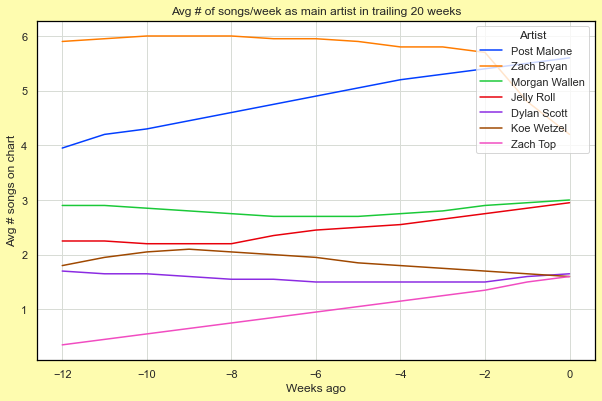

In [81]:
value_metric = 'recent_weeks_main_artist' # 'recent_weeks_artist' to include featured song weeks
graph = sns.lineplot(
    data = df_artist_ranking[
        df_artist_ranking['artist_id'].isin(top_artists)
      ].pivot(
        index = 'artist_name'
        , columns = 'weeks_ago'
        , values = value_metric
      ).loc[
         df_artist_ranking_over_time[0].keys()[:len(top_artists)] # maintain order from rank
      ].fillna(np.inf).T 
      / n_weeks_for_recent
    , dashes = False
    , palette = 'bright'
)
graph.set(
    title = f'Avg # of songs/week as main artist in trailing {n_weeks_for_recent} weeks'
    , ylabel = 'Avg # songs on chart'
    , xlabel = 'Weeks ago'
)

plt.legend(title = 'Artist')
graph.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

In [49]:
# Current artist rankings
pd.set_option('display.max_rows', 115)
cols = list(df_artist_ranking.columns)
col_nums = { col:ix for (col,ix) in zip(cols, range(len(cols))) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact \
    .loc[:, 1 : len(cols) - 2 ][
        (df_artist_ranking['weeks_ago'] == 0)
        # & (df_artist_ranking['artist_name'].isin(current_artists))
].head(100)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Post Malone,0,112,112,112,129,134,134,18,18,18,19,20,20,2.0,2.0,1.0,1,2024-04-09
1,Zach Bryan,0,84,84,84,343,343,343,13,13,13,30,30,30,5.0,5.0,1.0,1,2024-01-06
2,Morgan Wallen,0,37,60,77,241,279,328,3,5,6,7,10,12,1.0,1.0,1.0,1,2024-01-06
3,Jelly Roll,0,40,59,83,128,185,228,5,6,8,8,10,12,3.0,3.0,3.0,3,2024-01-06
4,Dylan Scott,0,19,33,33,57,99,99,2,3,3,2,3,3,24.0,24.0,24.0,24,2024-01-06
5,Koe Wetzel,0,32,32,32,55,55,55,3,3,3,4,4,4,5.0,5.0,5.0,5,2024-03-19
6,Zach Top,0,32,32,32,32,32,32,3,3,3,3,3,3,10.0,10.0,10.0,10,2024-08-23
7,Riley Green,0,27,27,47,67,67,91,3,3,4,4,4,5,24.0,7.0,15.0,7,2024-01-06
8,Shaboozey,0,27,27,27,46,46,46,4,4,4,5,5,5,1.0,1.0,1.0,1,2024-04-26
9,Lainey Wilson,0,26,26,31,62,97,102,3,3,4,4,5,6,14.0,14.0,8.0,8,2024-01-06


In [54]:
df_artist_ranking_change

,artist_id,artist_name,weeks_ago,recent_weeks_lead_artist,recent_weeks_main_artist,recent_weeks_artist,all_weeks_lead_artist,all_weeks_main_artist,all_weeks_artist,recent_num_songs_lead_artist,recent_num_songs_main_artist,recent_num_songs_artist,all_num_songs_lead_artist,all_num_songs_main_artist,all_num_songs_artist,recent_peak_position_as_main_artist,recent_peak_position,overall_peak_position_as_main_artist,overall_peak_position,artist_rank
0,15,Post Malone,0,+2,+2,+2,,,,,,,,,,,,,,
1,1,Zach Bryan,0,-12,-12,-12,,,,-4,-4,-4,,,,,,,,
2,2,Morgan Wallen,0,,+1,,,,,,,,,,,,,,,
3,5,Jelly Roll,0,+1,+2,+2,,,,,,,,,,,,,,
4,7,Dylan Scott,0,,+1,+1,,,,,,,,,,-2.0,↗ 2,,,↗ 1
5,16,Koe Wetzel,0,-1,-1,-1,,,,,,,,,,-1.0,↗ 1,,,↘ 1
6,53,Zach Top,0,+2,+2,+2,,,,,,,,,,,,,,
7,39,Riley Green,0,+1,+1,+1,,,,,,,,,,,,,,↗ 1
8,25,Shaboozey,0,+2,+2,+2,,,,,,,,,,,,,,↗ 2
9,11,Lainey Wilson,0,,,,,,,,,,,,,-1.0,↗ 1,,,


In [55]:
# As above, but changes rather than current status
pd.options.display.float_format = '{:+,.0f}'.format
df_artist_ranking_change = df_artist_ranking.copy()[
    (df_artist_ranking['weeks_ago'] == 0)
    & (df_artist_ranking['recent_weeks_artist'] != 0)
]
df_artist_ranking_change.drop(['artist_debut_date_in_data'], axis = 1, inplace = True)
ranking_cols = list(df_artist_ranking_change.columns)

for row in df_artist_ranking_change.iterrows():
    this_artist = row[1]['artist_id']
    this_change_row = df_artist_ranking_change[
        df_artist_ranking_change['artist_id'] == this_artist
    ]
    row_last_week = df_artist_ranking[
        (df_artist_ranking['weeks_ago'] == -1)
        & (df_artist_ranking['artist_id'] == this_artist)
    ]
    for col_name, val_this_week in row[1][3:].items():
        val_last_week = np.array(row_last_week[col_name])[0]
        val_change = round(val_this_week - val_last_week, 0)
        
        if col_name in ['artist_rank', 'recent_peak_position']:
            if val_change > 0: # Higher numbers are "lower" on the chart
                str_change = '↘ ' + str(round(val_change))
            elif val_change == 0:
                str_change = ''
            elif val_change < 0: # Lower numbers are "higher" on the chart
                str_change = '↗ ' + str(round(abs(val_change)))
                
        else:
            val_change = val_this_week - val_last_week
            if val_change > 0:
                str_change = '+' + str(val_change)
            elif val_change == 0:
                str_change = ''
            elif val_change < 0:
                str_change = str(val_change)
        
        df_artist_ranking_change.loc[this_change_row.index[0], col_name] = str_change


df_changes = df_artist_ranking_change[[
    'artist_name'
    , 'artist_rank'
    , 'recent_weeks_main_artist'
    , 'recent_weeks_lead_artist'
    , 'recent_weeks_artist'
    , 'recent_num_songs_main_artist'
    , 'recent_num_songs_lead_artist'
    , 'recent_num_songs_artist'
    , 'recent_peak_position'
    , 'overall_peak_position'
]]

df_changes.columns = [
    'Artist'
    , 'Rank'
    , 'Weeks (Main)' # TODO: multilevel column index
    , 'Weeks (Lead)'
    , 'Weeks (Any)'
    , 'Songs (Main)'
    , 'Songs (Lead)'
    , 'Songs (Any)'
    , 'L26W Peak Position'
    , 'Peak Position Ever'
]

df_changes.style.set_properties(**{'text-align': 'left'})
# df_changes.style.set_sticky(axis = 1) # TOFIX

,Artist,Rank,Weeks (Main),Weeks (Lead),Weeks (Any),Songs (Main),Songs (Lead),Songs (Any),L26W Peak Position,Peak Position Ever
0,Post Malone,,+2,+2,+2,,,,,
1,Zach Bryan,,-12,-12,-12,-4,-4,-4,,
2,Morgan Wallen,,+1,,,,,,,
3,Jelly Roll,,+2,+1,+2,,,,,
4,Dylan Scott,↗ 1,+1,,+1,,,,↗ 2,
5,Koe Wetzel,↘ 1,-1,-1,-1,,,,↗ 1,
6,Zach Top,,+2,+2,+2,,,,,
7,Riley Green,↗ 1,+1,+1,+1,,,,,
8,Shaboozey,↗ 2,+2,+2,+2,,,,,
9,Lainey Wilson,,,,,,,,↗ 1,


In [56]:
%%sql df_weeks_for_artist <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
    , s2a.artist_id
    , art.artist_name
    , s2a.relationship_type
    , art.pct_female
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
LEFT JOIN raw_db.billboard.song_to_artist s2a
    ON br.song_id = s2a.song_id
LEFT JOIN raw_db.billboard.artist art
    ON s2a.artist_id = art.artist_id
ORDER BY 1 ASC

In [57]:
df_by_reln_type = df_weeks_for_artist.groupby(
        ['billboard_observation_date', 'relationship_type']
    ).agg(['mean', 'count'])['pct_female'].reset_index()
df_by_reln_type['wtd_avg_numerator'] = df_by_reln_type['mean'] * df_by_reln_type['count']

df_all_credits = df_by_reln_type.groupby('billboard_observation_date').sum()
df_all_credits['mean'] = df_all_credits['wtd_avg_numerator'] / df_all_credits['count']
df_all_credits.reset_index(inplace = True)
df_all_credits['relationship_type'] = 'All credited artists'

df_mains = df_by_reln_type[
    df_by_reln_type['relationship_type'].isin(['Lead artist', 'Other main artist'])
].groupby('billboard_observation_date').sum()
df_mains['mean'] = df_mains['wtd_avg_numerator'] / df_mains['count']
df_mains.reset_index(inplace = True)
df_mains['relationship_type'] = 'All main artists'

col_order = [
    'billboard_observation_date'
    , 'relationship_type'
    , 'mean'
    , 'count'
    , 'wtd_avg_numerator'
]

df_pct_female = pd.concat([
    df_by_reln_type
    , df_all_credits[col_order]
    , df_mains[col_order]
])

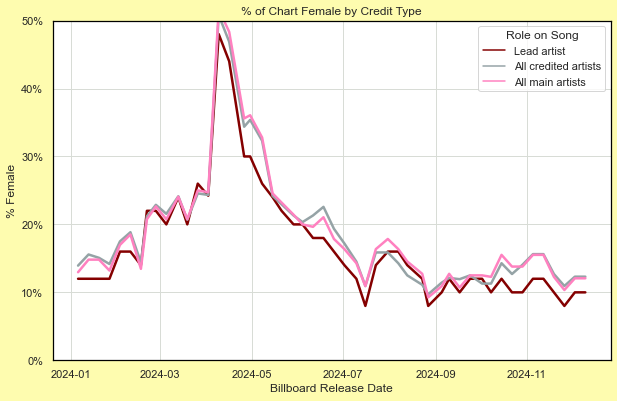

In [58]:
palette = {
    'Lead artist' : 'xkcd:dark red'
    , 'All main artists' : 'xkcd:pink'
    , 'All credited artists' : 'xkcd:cool gray'
}

graph = sns.lineplot(
    data = df_pct_female[
        df_pct_female['relationship_type'].isin(palette.keys())
    ]
    , x = 'billboard_observation_date'
    , y = 'mean'
    , hue = 'relationship_type'
    , palette = palette
    , linewidth = 2.5 # TODO make variable
).set(
    title = '% of Chart Female by Credit Type'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = '% Female'
    , ylim = [0, 0.5]
)#.tick_params(axis='x', colors='red') # TOFIX

plt.legend(title = 'Role on Song')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
# plt.hlines([0.5], date('2024-04-01'), date('2024-10-01')) #TOFIX

In [59]:
credit_type_to_linestyle = {
    'Lead artist' : 'solid'
    , 'Other main artist' : 'dashed'
    , 'Featured artist' : 'dotted'
}

In [61]:
# TODO enrich with n_songs from above
df_weeks_for_artist[
    df_weeks_for_artist['billboard_observation_date'] == billboard_observation_date
].groupby('artist_name').count().iloc[:,1].loc[
    lambda x: x > 1
    # lambda x: x == 1
].sort_values(ascending = False)

artist_name
Jelly Roll       4
Morgan Wallen    4
Post Malone      4
Ella Langley     3
Riley Green      3
Shaboozey        3
Zach Bryan       3
Blake Shelton    2
Dylan Scott      2
Kane Brown       2
Zach Top         2
Name: song_id, dtype: int64

Bad Luck: Zach Top(53)
Last Of My Kind: Shaboozey(25) feat. Paul Cauthen(120)

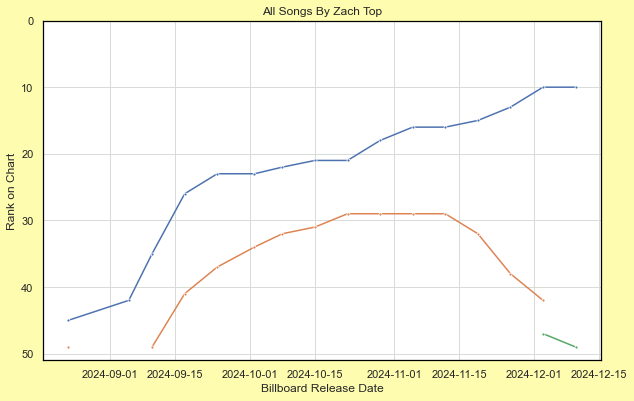

In [92]:
# For now, manual artist name selection
# TODO: Create charts for every artist on this week's chart at once
artist_name = 'Zach Top' # TODO: use artist ID, but label with artist_name

df_weeks_this_artist = df_weeks_for_artist.query(
    f"artist_name == '{artist_name}'"
)

sns.color_palette('Paired') # TOFIX
for _, row in df_weeks_this_artist.pivot( # TODO no pivot to support legend in char 'song_name'
    index = 'song_id'
    , columns = 'billboard_observation_date' #TODO: weeks ago
    , values = 'billboard_rank'
).fillna(
    np.inf # suppresses only if a different song is on the chart that week
).iterrows():
    graph = sns.lineplot(
        data = row
        , linestyle = credit_type_to_linestyle[
            df_weeks_this_artist[
                df_weeks_this_artist['song_id'] == row.name
            ].groupby('relationship_type').count().iloc[0].name
        ]
        , marker = '.'
    )
    
graph.set(
    title = f'All Songs By {artist_name}'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = 'Rank on Chart'
    , ylim = [0, 51]
)
graph.axes.invert_yaxis()

In [64]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = billboard_observation_date
comparison_observation_date = '2024-11-26'

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬──────────────────┬────────────────┐
│ song_id │    song_name     │ ranking_before │
│  int32  │     varchar      │     int32      │
├─────────┼──────────────────┼────────────────┤
│      39 │ Beautiful As You │             10 │
│      43 │ Pink Skies       │             11 │
│     238 │ Texas            │             29 │
│      45 │ Wanna Be Loved   │             41 │
│     211 │ One Bad Habit    │             50 │
└─────────┴──────────────────┴────────────────┘



In [51]:
# TODO consider adding a measurement start date column
    # for Friday of each week based on observation date

In [93]:
%%sql df_weeks <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
ORDER BY 1 ASC

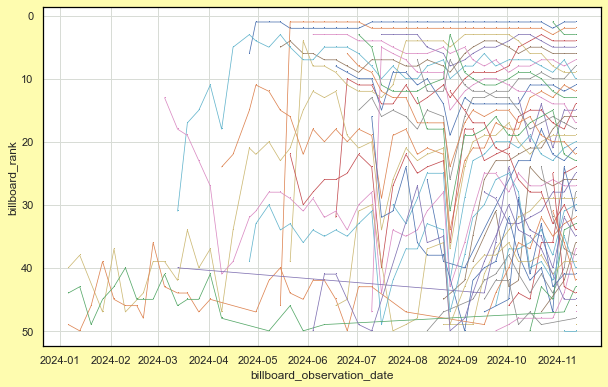

In [94]:
for _, row in df_weeks.query(
    # f"billboard_observation_date == '2024-09-10'"
    f"billboard_observation_date == '{billboard_observation_date}'"
).sort_values('billboard_rank').iterrows():
    this_song = df_weeks[
        df_weeks['song_id'] == row['song_id']
    ].sort_values('billboard_observation_date').fillna(
        np.inf # Not working fully to show gaps as missing
    )
    
    graph = sns.lineplot(
        data = this_song
        , x = 'billboard_observation_date' # TODO: weeks back instead of obs date
        , y = 'billboard_rank'
        , marker = ',' # TODO: add back with bigger chart
        , dashes = False
        , linewidth = 0.75
        # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
    )#.set_title(this_song.reset_index()['song_name'][0])
    
graph.axes.invert_yaxis()
# TODO: Spin x-axis labels
# TODO: Make this about 4x bigger

In [59]:
# TODO maybe: Each song on its own tile, rather than overlapped